# Srovnání komprese dat pomocí SVD a waveletů

In [319]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pywt
import time


NAČTENÍ OBRÁZKŮ A DEFINICE POMĚRŮ ULOŽENÍ
1 Obraz - šum
2 Obraz - vozr-svetr
3 Obraz - obraz krajiny

In [320]:

image_noice = np.copy(cv.imread('data/vesmir-sum.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_svetr = np.copy(cv.imread('data/image-pattern.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_normal = np.copy(cv.imread('data/mesto-normal.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
N = 8 # počet různých kompresních poměrů
keep_ratios = np.linspace(0.01, 0.5, N)

Funkce pro výpočet PSNR mezi priginálem apo kompresi

In [321]:

def PSNR (I1, I2):

    mse = np.mean((I1 - I2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# SVD 

In [322]:
#komprese
def svd_compress(image, k):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    return U[:, :k], S[:k], VT[:k, :]
#dekomprese
def svd_reconstruct(Uk, Sk, VTk):
    return Uk @ np.diag(Sk) @ VTk

# Vypočet uložených hodnot pro SVD kompresi
def svd_storage(m, n, k):
    return k * (m + n + 1)


# Inicializace výsledných seznamů
reconstructed_images = []
PSNR_SVD = []
k_values = []
compression_ratios_svd = []
casy_komprese_svd = []
casy_dekomprese_svd = []
# Zpracování každého obrázku
for image in [image_noice, image_svetr, image_normal]:
    m, n = image.shape
    original_size = m * n
    print("\nProcessing new image:")
    # Zpracování každého poměru uložení
    for ratio in keep_ratios:
        # Výpočet hodnoty k
        targeted_size = original_size * ratio
        k = int((targeted_size) / (m + n + 1))
        k_values.append(k)
        # SVD komprese a dekomprese
        start_time_compression = time.time()

        Uk, Sk, VTk = svd_compress(image, k)

        end_time_compression = time.time()
        compression_time = end_time_compression - start_time_compression
        casy_komprese_svd.append(compression_time)

        start_time_decompression = time.time()

        A_k = svd_reconstruct(Uk, Sk, VTk)

        end_time_decompression = time.time()
        decompression_time = end_time_decompression - start_time_decompression
        casy_dekomprese_svd.append(decompression_time)

        reconstructed_images.append(A_k)
        # Výpočet kompresního poměru a PSNR
        compression_ratios_svd.append(original_size / (k * (m+n+1)))
        stored = svd_storage(m, n, k)
        psnr = PSNR(image, A_k)
        PSNR_SVD.append(psnr)
        print(f"k={k:3} | Stored values={stored} | Compression ratio={ratio:.2f}x | Verification compression={compression_ratios_svd[-1]:.2f}x | PSNR={psnr:.2f} dB")

# Casy por SVD kompresi a dekompresi
average_compression_time_svd = np.mean(casy_komprese_svd)
average_decompression_time_svd = np.mean(casy_dekomprese_svd)
print(f"Průměrný SVD čas komprese: {average_compression_time_svd:.6f} s")
print(f"Průměrný SVD čas dekomprese: {average_decompression_time_svd:.6f} s")



Processing new image:
k=  7 | Stored values=21847 | Compression ratio=0.01x | Verification compression=105.46x | PSNR=20.70 dB
k= 59 | Stored values=184139 | Compression ratio=0.08x | Verification compression=12.51x | PSNR=22.24 dB
k=110 | Stored values=343310 | Compression ratio=0.15x | Verification compression=6.71x | PSNR=23.47 dB
k=162 | Stored values=505602 | Compression ratio=0.22x | Verification compression=4.56x | PSNR=24.67 dB
k=214 | Stored values=667894 | Compression ratio=0.29x | Verification compression=3.45x | PSNR=25.84 dB
k=265 | Stored values=827065 | Compression ratio=0.36x | Verification compression=2.79x | PSNR=26.97 dB
k=317 | Stored values=989357 | Compression ratio=0.43x | Verification compression=2.33x | PSNR=28.14 dB
k=369 | Stored values=1151649 | Compression ratio=0.50x | Verification compression=2.00x | PSNR=29.30 dB

Processing new image:
k=  7 | Stored values=21007 | Compression ratio=0.01x | Verification compression=102.82x | PSNR=17.49 dB
k= 57 | Stored

Vykreslení originálu a obrázku po dekompresi

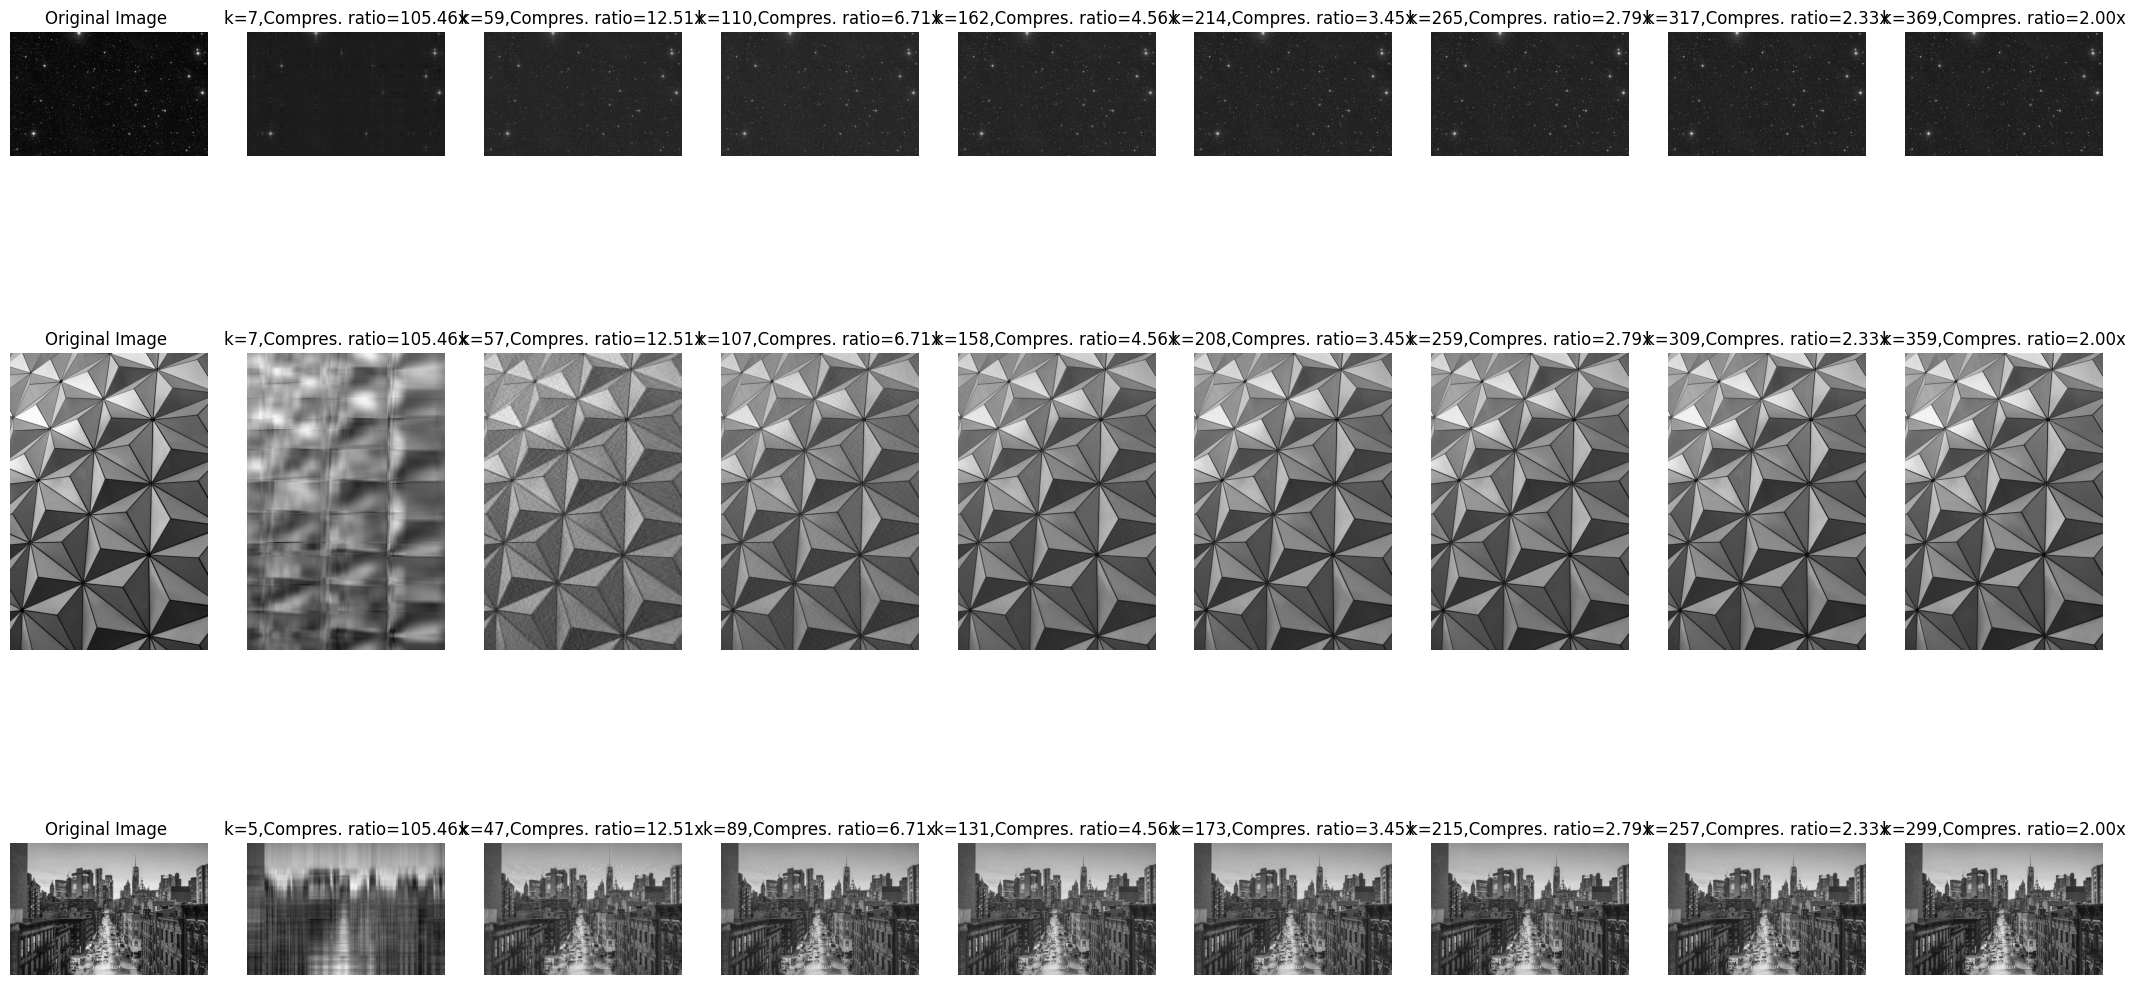

In [333]:
# Vykreslení originálu a obrázků po dekompresí, každý řádek pro jeden obrázek
cols = len(reconstructed_images) // 3 + 1

# Vytvoření figure a axes
fig, axes = plt.subplots(3, cols, figsize=(3*cols, 15))
# Pro každý obrázek vykreslíme originál a rekonstruované obrázky
for img_idx, image in enumerate([image_noice, image_svetr, image_normal]):
    # Originál
    axes[img_idx, 0].imshow(image, cmap='gray')
    axes[img_idx, 0].set_title('Original Image ')
    axes[img_idx, 0].axis('off')


    start = img_idx * (cols - 1)
    # Rekonstruované obrázky
    for i, A_k in enumerate(reconstructed_images[start:start + (cols - 1)]):
        axes[img_idx, i + 1].imshow(A_k, cmap='gray')
        axes[img_idx, i + 1].set_title(f'k={k_values[start + i]},Compres. ratio={compression_ratios_svd[i]:.2f}x')
        axes[img_idx, i + 1].axis('off')
# Uložení obrázku
fig.savefig('results/svd_compression_all.png', bbox_inches='tight')
plt.show()

# WAVELET

In [327]:
image_noice = np.copy(cv.imread('data/vesmir-sum.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_svetr = np.copy(cv.imread('data/image-pattern.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_normal = np.copy(cv.imread('data/mesto-normal.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))

In [328]:
# Komprese 
def wavelet_compress_by_budget(image, level, wavelet, keep_ratio):
    # Vypočet koeficientů waveletovy transformace
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)
    # Tvarování do 1D pole pro snadnou manipulaci
    flat = coeffs_array.ravel()
    # Určení počtu koeficientů k ponechání
    n_total = flat.size
    n_keep = int(n_total * keep_ratio)
    # Získání indexů největších koeficientů
    idx = np.argsort(np.abs(flat))
    mask = np.zeros_like(flat, dtype=bool)
    mask[idx[-n_keep:]] = True
    # Vytvoření nového pole s ponechanými koeficienty
    flat_compressed = np.zeros_like(flat)
    flat_compressed[mask] = flat[mask]
    # Reshape zpět do původního tvaru
    coeffs_array_compressed = flat_compressed.reshape(coeffs_array.shape)
    return coeffs_array_compressed, coeff_slices

# Dekomprese z pole koeficientů
def wavelet_reconstruct_from_array(coeffs_array, coeff_slices, wavelet):
    coeffs = pywt.array_to_coeffs(coeffs_array, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, wavelet)

# Počet nenulových koeficientů
def count_nonzero_coeffs(coeffs):
    count = np.count_nonzero(coeffs)
    return count

# Inicializace výsledných seznamů
level = 2
reconstructed_images_wavelet = []
PSNR_Wavelet = []
compression_ratios_wavelet = []
casy_komprese_wavelet = []
casy_dekomprese_wavelet = []

# Zpracování každého obrázku
for image in [image_noice, image_svetr, image_normal]:
    print("\nProcessing new image:")
    original_size = image.size
    # Zpracování každého poměru uložení
    for ratios in keep_ratios:
        # Wavelet komprese a dekomprese
        start_time_compression = time.time()
        coeffs_array_compressed, coeff_slices = wavelet_compress_by_budget(image, level=level, wavelet='db1', keep_ratio=ratios)
        end_time_compression = time.time()
        compression_time = end_time_compression - start_time_compression
        casy_komprese_wavelet.append(compression_time)

        start_time_decompression = time.time()
        I_T = wavelet_reconstruct_from_array(coeffs_array_compressed, coeff_slices, wavelet='db1')
        end_time_decompression = time.time()
        decompression_time = end_time_decompression - start_time_decompression
        casy_dekomprese_wavelet.append(decompression_time)


        reconstructed_images_wavelet.append(I_T)
        # Výpočet kompresního poměru a PSNR
        nonzero = count_nonzero_coeffs(coeffs_array_compressed)
        total_coeffs = coeffs_array_compressed.size
        compression_ratios_wavelet.append(total_coeffs / nonzero)
        # Uložení prahu
        psnr = PSNR(image, I_T)
        PSNR_Wavelet.append(psnr)
        print(f"Keep ratio={ratios:.2f} | Non-zero coeffs= {nonzero} | "
              f"Compression ratio={compression_ratios_wavelet[-1]:.2f}x | PSNR={psnr:.2f} dB")

# Casy por Wavelet kompresi a dekompresi
average_compression_time_wavelet = np.mean(casy_komprese_wavelet)
average_decompression_time_wavelet = np.mean(casy_dekomprese_wavelet)
print(f"Průměrný Wavelet čas komprese: {average_compression_time_wavelet:.6f} s")
print(f"Průměrný Wavelet čas dekomprese: {average_decompression_time_wavelet:.6f} s")



Processing new image:
Keep ratio=0.01 | Non-zero coeffs= 23040 | Compression ratio=100.00x | PSNR=22.72 dB
Keep ratio=0.08 | Non-zero coeffs= 184319 | Compression ratio=12.50x | PSNR=28.88 dB
Keep ratio=0.15 | Non-zero coeffs= 345600 | Compression ratio=6.67x | PSNR=32.45 dB
Keep ratio=0.22 | Non-zero coeffs= 506879 | Compression ratio=4.55x | PSNR=34.46 dB
Keep ratio=0.29 | Non-zero coeffs= 668160 | Compression ratio=3.45x | PSNR=36.25 dB
Keep ratio=0.36 | Non-zero coeffs= 829440 | Compression ratio=2.78x | PSNR=38.01 dB
Keep ratio=0.43 | Non-zero coeffs= 990719 | Compression ratio=2.33x | PSNR=39.82 dB
Keep ratio=0.50 | Non-zero coeffs= 1152000 | Compression ratio=2.00x | PSNR=41.78 dB

Processing new image:
Keep ratio=0.01 | Non-zero coeffs= 21600 | Compression ratio=100.00x | PSNR=8.60 dB
Keep ratio=0.08 | Non-zero coeffs= 172799 | Compression ratio=12.50x | PSNR=33.34 dB
Keep ratio=0.15 | Non-zero coeffs= 324000 | Compression ratio=6.67x | PSNR=46.73 dB
Keep ratio=0.22 | Non-zero

Vykreslení originálu a obrázku po dekompresi

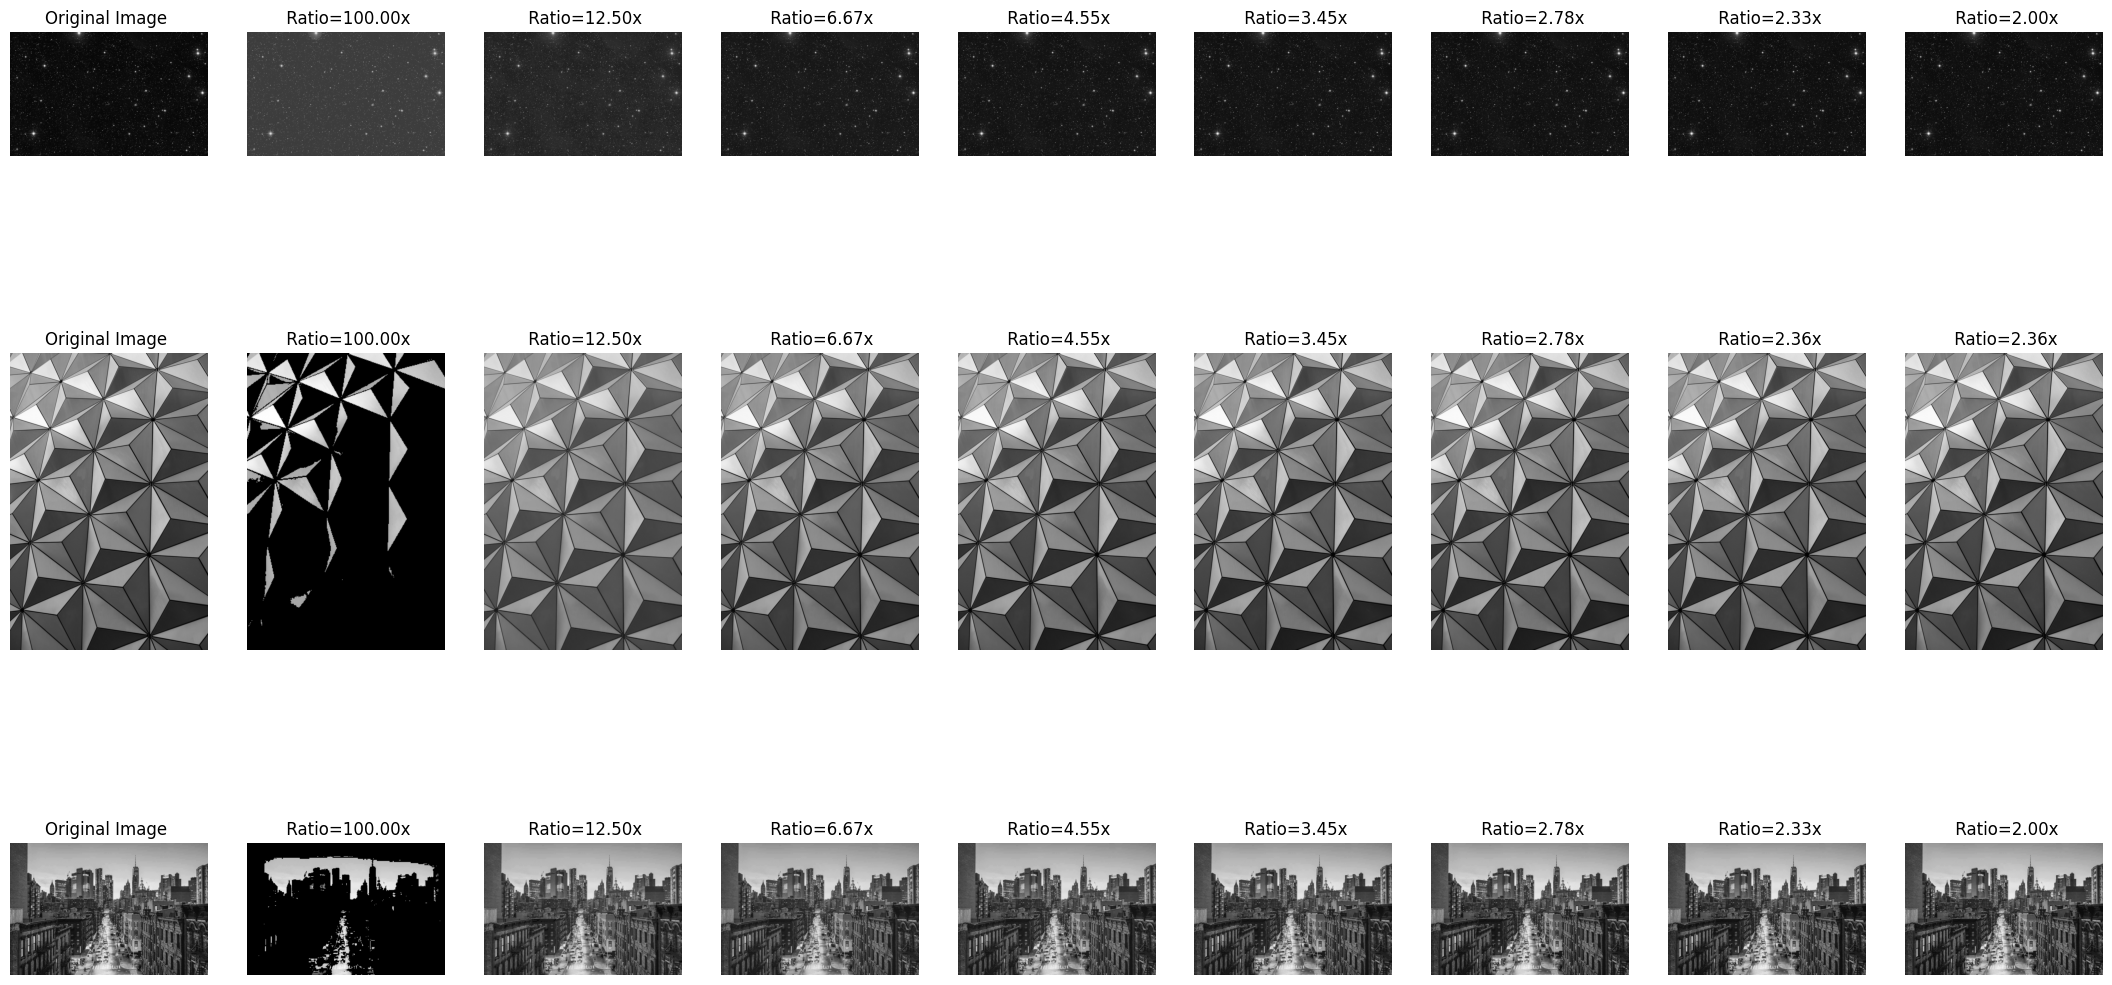

In [329]:
# Vykreslení originálu a obrázků po dekompresí, každý řádek pro jeden obrázek
cols = len(reconstructed_images_wavelet) // 3 + 1
# Vytvoření figure a axes
fig, axes = plt.subplots(3, cols, figsize=(cols * 3, 15))
# Pro každý obrázek vykreslíme originál a rekonstruované obrázky
for img_idx, image in enumerate([image_noice, image_svetr, image_normal]):
    # Originál
    axes[img_idx, 0].imshow(image, cmap='gray')
    axes[img_idx, 0].set_title('Original Image ')
    axes[img_idx, 0].axis('off')


    start = img_idx * (cols - 1)
    # Rekonstruované obrázky
    for i, A_k in enumerate(reconstructed_images_wavelet[start:start + (cols - 1)]):
        axes[img_idx, i + 1].imshow(A_k, cmap='gray')
        axes[img_idx, i + 1].set_title(f' Ratio={compression_ratios_wavelet[start + i]:.2f}x')
        axes[img_idx, i + 1].axis('off')
# Uložení obrázku
fig.savefig('results/wavelet_compression_all.png', bbox_inches='tight')
plt.show()

# Vykreslení výsledků porovnání SVD a Wavelet komprese

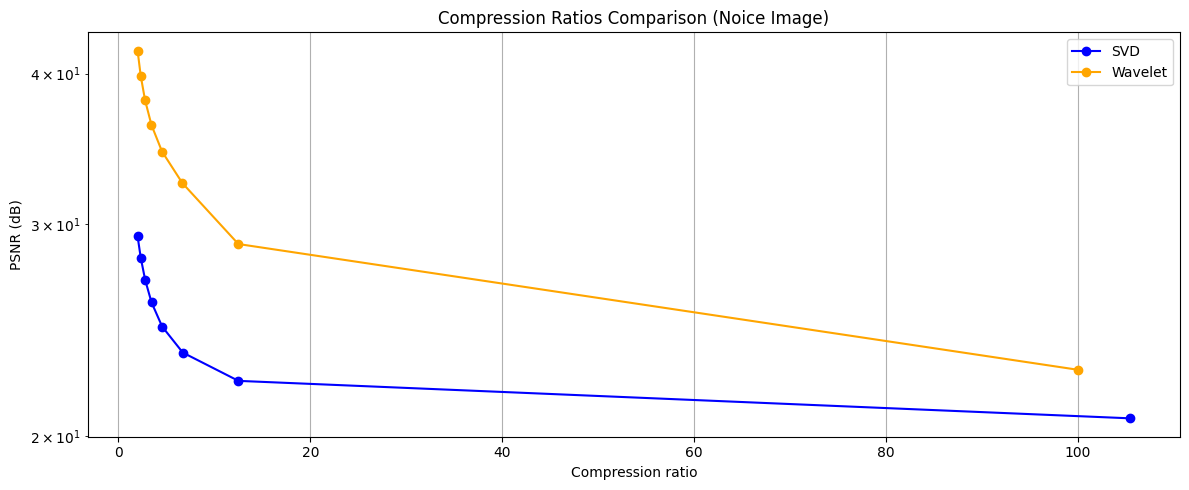

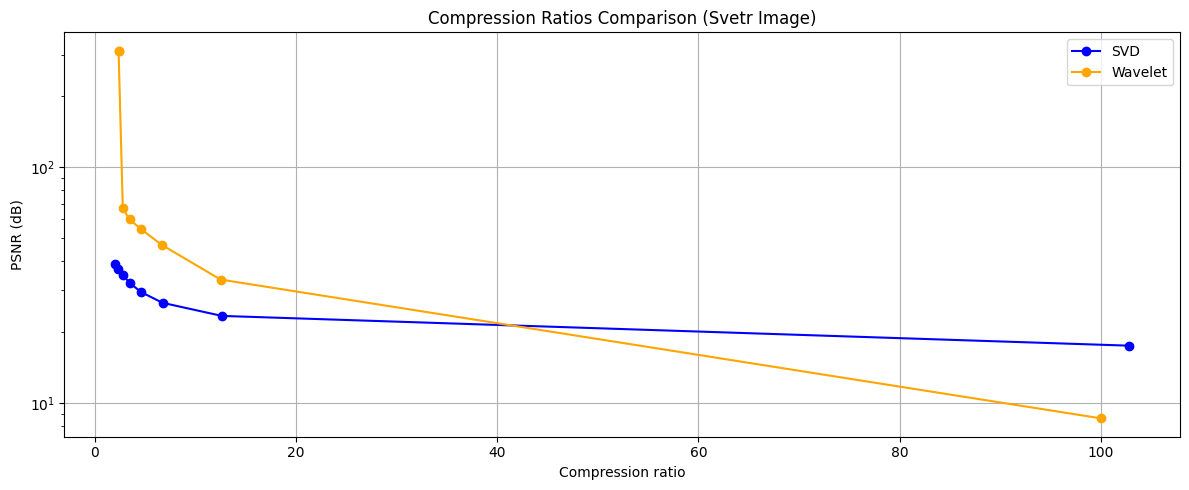

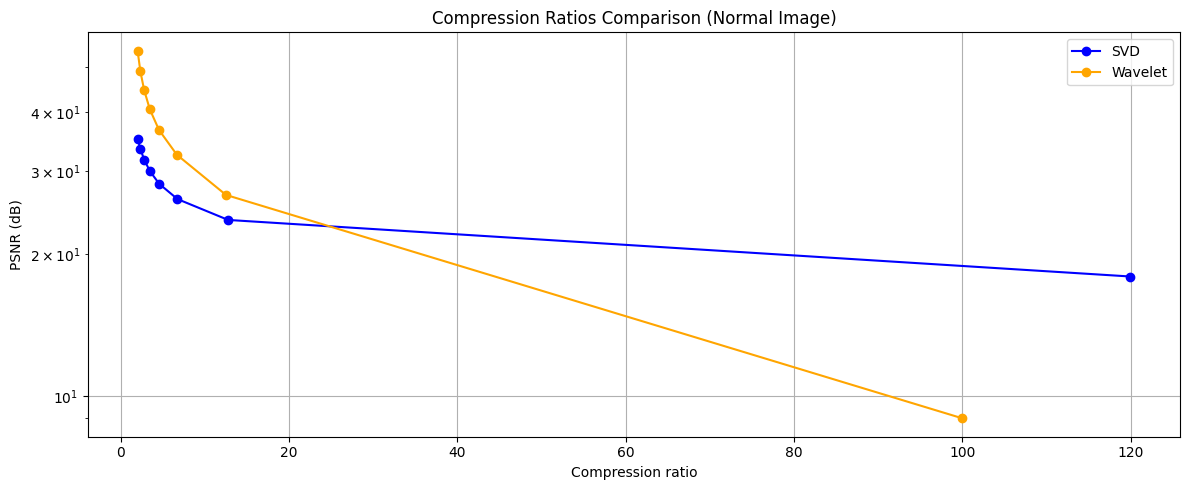

In [330]:
start_idx = 0
image_names = ['Noice Image', 'Svetr Image', 'Normal Image']
# Cyklus pro vykreslení každého obrázku
for idx, image_name in enumerate(image_names):
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))

    # Vypočet správných hranic řezu pro tento obrázek (každý obrázek má len(keep_ratios) záznamů)
    end_idx = start_idx + len(keep_ratios)
    # VykresleníSVD a Wavelet dat pro aktuální obrázek
    x_svd_chunk = compression_ratios_svd[start_idx:end_idx]
    y_svd_chunk = PSNR_SVD[start_idx:end_idx]
    axs.plot(x_svd_chunk, y_svd_chunk, marker='o', color='blue')

    x_wav_chunk = compression_ratios_wavelet[start_idx:end_idx]
    y_wav_chunk = PSNR_Wavelet[start_idx:end_idx]
    axs.plot(x_wav_chunk, y_wav_chunk, marker='o', color='orange')
    # Vlastnosti grafu
    axs.set_ylabel("PSNR (dB)")
    axs.set_yscale('log')
    axs.set_xlabel("Compression ratio")

    axs.set_title("Compression Ratios Comparison (" + image_name + ")")
    axs.grid(True)

    plt.tight_layout()
    plt.legend(['SVD', 'Wavelet'])
    plt.show()

    # Dalsí obraz
    start_idx = end_idx


 Heatmapa 

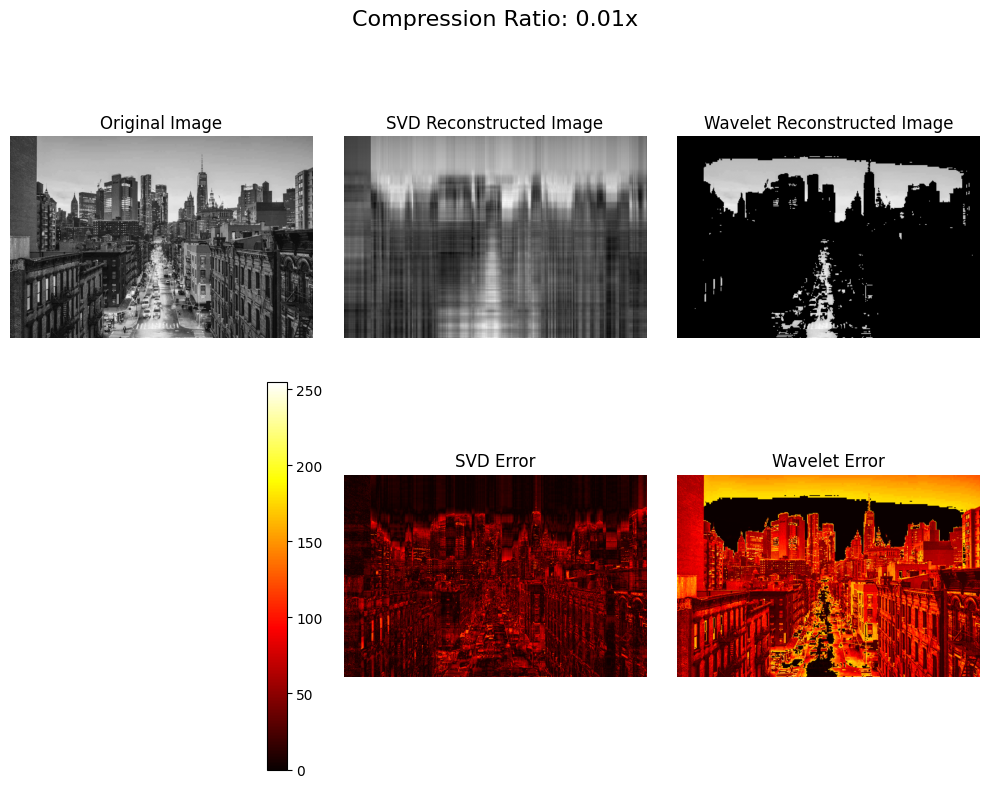

In [ ]:

def heatmap_results(original_image, svd_reconstructed, wavelet_reconstructed, ratio):
    # Vypočet chybových map
    error_svd = np.abs(original_image - svd_reconstructed)
    error_wavelet = np.abs(original_image - wavelet_reconstructed)
    # Maximální hodnota pro škálování barevné mapy
    max_error = max(np.max(error_svd), np.max(error_wavelet))
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    fig.suptitle(f'Compression Ratio: {ratio:.2f}x', fontsize=16)
    # Vykreslení obrázků
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(svd_reconstructed, cmap='gray')
    axs[0, 1].set_title('SVD Reconstructed Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(wavelet_reconstructed, cmap='gray')
    axs[0, 2].set_title('Wavelet Reconstructed Image')
    axs[0, 2].axis('off')

    # Vykreslení heatmap
    axs[1, 1].imshow(error_svd, cmap='hot', vmin=0, vmax=max_error)
    axs[1, 1].set_title('SVD Error')
    axs[1, 1].axis('off')

    colormap_Range=axs[1, 2].imshow(error_wavelet, cmap='hot', vmin=0, vmax=max_error)
    axs[1, 2].set_title('Wavelet Error')
    axs[1, 2].axis('off')

    # Přidání legendy pro chybové mapy
    fig.colorbar(colormap_Range, ax=axs[1, 0])
    axs[1, 0].set_visible(False)

    plt.tight_layout()
    fig.savefig('results/comparison_visualization.png', bbox_inches='tight')
    plt.show()


n = 0
# 0: noice, 1: svetr, 2: normal
image_index=2
# Seznam originálních obrázků
original_images = [image_noice, image_svetr, image_normal]
# Vykreslení heatmap pro zvolený obrázek a kompresní poměr
heatmap_results(original_images[image_index], reconstructed_images[n+(image_index*N)], reconstructed_images_wavelet[n+(image_index*N)], keep_ratios[n])
